# Lecture 25 - Variational Inference

## Objectives

+ to introduce variational inference as a class of techniques for approximate Bayesian Inference. 
+ to use automatic differentiation variational inference (ADVI) for performing Bayesian inference, using `PyMC3`.

## References 

+ Variational Inference: A Review for Statisticians (Blei et al, 2018) - https://arxiv.org/pdf/1601.00670.pdf.

+ Automatic Differentiation Variational Inference (Kucukelbir et al, 2016) - https://arxiv.org/pdf/1603.00788.pdf.

+ Autoencoding Variational Bayes (Kingma and Welling, 2014) - https://arxiv.org/pdf/1312.6114.pdf

+ Black Box Variational Inference (Ranganath et al, 2013) - https://arxiv.org/pdf/1401.0118.pdf.

## Additional Reading 

+ Stein Variational Gradient Descent (Liu and Wang, 2016) (https://arxiv.org/pdf/1608.04471.pdf)

+ Variational Inference with Normalizing Flows (Rezende and Mohamed, 2016) - https://arxiv.org/pdf/1505.05770.pdf.


In [1]:
import numpy as np
import theano as th
from theano import tensor as tt, shared
import pymc3 as pm

from scipy import stats as st 
from scipy import optimize 


import pandas as pd
import arviz as az
from graphviz import Digraph

import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()
%matplotlib inline

## Bayesian Inference 

### Quick Review 

Once again, let's begin with a review of Bayesian inference. 

Our goal is to derive a probability distribution over unknown quantities (or latent variables), conditional on any observed data (i.e. a posterior distribution). 
Without loss of generality, we denote all unknown quantities in our model as $\theta$ and the observed data as $\mathcal{D}$. 

We start with a description of our prior state of knowledge over $\theta$ - $p(\theta)$. 

We then specify a conditional probabilistic model that links the observed data with the unknown quantities $p(\mathcal{D}|\theta)$ (the likelihood). 
We want $p(\theta|\mathcal{D})$ which we know, from Bayes rule, to be:
$
p(\theta | \mathcal{D}) \propto p(\mathcal{D}, \theta).
$

The posterior distribution $p(\theta | \mathcal{D})$ captures our state of knowledge about $\theta$ conditional on all the information available to us $\mathcal{D}$. 

In the Bayesian framework, predictions about unseen data (or test data), are posed as expectations over this posterior distribution.


### What is the problem? 

Unfortunately, as you already know, the posterior distribution is more often than not unavailable in closed form. 
This is due to the intractablity of the *evidence* (or *marginal likelihood*), i.e., the denominator in the Bayes' rule, $Z = \int p(\theta, \mathcal{D}) \mathrm{d}\theta$.
Infact, there are only a small class of prior-posterior models that admit closed form expressions for the posterior distributions (*conjugate models*). 

### Approximating the posterior

There are several approaches to do this:

1. The posterior density $p(\theta | \mathcal{D})$ is approximated with a point mass density, i.e., $p(\theta | \mathcal{D})  = \delta_{\theta^*}(\theta)$, where, $\delta_{\theta^*}(\theta) = \begin{cases}  1, \text{ if } \theta = \theta^*, \\  0 \text{ otherwise.} \end{cases}$
This is the well-known *maximum a-posteriori* (MAP) estimation procedure. The parameter $\theta^*$ is obtained as the solution of the optimization problem, $\theta^* = \underset{\theta}{\mathrm{argmax}} p(\theta, \mathcal{D})$. The MAP approximation is often justified by the assumption that the true posterior distribution $p(\theta|\mathcal{D})$ has a single, sharply peaked mode. In practice this approach often provides reasonable predictive accuracy but is unable to capture any of the epistemic uncertainty induced by limited data.

2. The posterior distribution is approximated with a finite number of particles, i.e., $p(\theta | \mathcal{D}) = \sum_{i=1}^{N} w^{(i)} \delta (\theta - \theta^{(i)})$.  The most popular class of techniques that approximates the posterior distribution this way is Markov Chain Monte Carlo (MCMC). Recall that the general idea of MCMC is to construct a discrete-time, reversible and ergodic Markov Chain whose equilibrium distribution is the target posterior distribution. The goal is to simulate the Markov Chain long enough that it enters it's equilibrium phase (i.e. target posterior density). Once this is accomplished, sampling from the Markov Chain is the same as sampling from the target posterior density. Since MCMC samples (in theory) directly from the posterior, the weights of the approximation $, w^{(i)}$ are simply set to 1. 
There are several other approaches to approximate probability densities with particle distributions such as Sequential Monte Carlo (SMC) (which developed primarily as tools for inferring latent variables in state-space models but can be used for general purpose inference) and Stein Variational Gradient Descent (SVGD). 

3. Set up a parameterized family of densities over the latent variables - $q_{\phi}(\theta)$, and infer the parameters, $\phi$ by solving an optimization problem of the form:
$$
\phi^{*} = \underset{\phi}{\mathrm{argmin}} \ \mathrm{D}[ p(\theta| \mathcal{D}) , q_{\phi}(\theta)], 
$$
where, $\mathrm{D}[\cdot, \cdot]$ is some measure of discrepancy between the approximate (or *variational*) posterior and the true posterior. 
Needless to say, we want to set up this optimization problem such that we only need to know $p(\theta | \mathcal{D})$ upto a multiplicative constant. 
*Variational Inference* (VI) is the name given to this general class of methods that seek to approximate the posterior this way. 


### Variational Inference 

Different VI procedures are obtained based on different choices of the approximating family $q_{\phi}(\cdot)$ and the functional $\mathrm{D}[\cdot, \cdot]$. The most standard choice for $\mathrm{D}$ is the *Kullback Leibler (KL) divergence*.
The KL divergence between two densities $q(\theta)$ and $p(\theta)$ is defined as follows: 
$$
\mathrm{KL}[q(\theta)|| p(\theta)] = \int q(\theta) \log \left( \frac{q(\theta)}{p(\theta)} \right) \mathrm{d}\theta = \mathbb{E}_{q(\theta)} \left[ \log \left( \frac{q(\theta)}{p(\theta)} \right) \right].
$$
The KL divergence is always non-negative, i.e., $\mathrm{KL}[q(\theta)|| p(\theta)] \ge 0$, with $\mathrm{KL}[q(\theta)|| p(\theta)] = 0$ implying that $q(\theta) = p(\theta)$ *almost everywhere*. 
Our inference goal can, therefore, be stated as follows - given a choice of a family of densities $q(\cdot)$, parameterized by $\phi$, what is the setting of $\phi$ that will return the closest match, i.e. minimum KL divergence, between the approximate posterior $q(\theta)$ and the true posterior $p(\theta|\mathcal{D})$?

This brings us to $q$ - the approximate posterior. Notice that we have made no assumptions on $q$ thus far. We can, ofcourse, pick any arbitrary distribution we want to approximate the posterior. However, in practice, we pick $q$ such that it satisfies some desirable properties:
1. If we know that a latent variable has finite support (positive reals for instance), we pick $q$ such $q$ itself has support on the same interval only. 
2. We would also like $q$ to be easy to sample from and easy to evaluate it's log probability since the variational objective requires computing an expectation over log probability ratios. A common simplfying assumption that enables easier sampling and log probability computation is the *mean-field* assumption - i.e., setting up approximation such that the individual latent variables are independent. If $\theta = (\theta_1, \theta_2, \dots, \theta_M)$ is the vector of latent variables, the mean-field assumption implies an approximation of the form,
$$
p(\theta|\mathcal{D}) \approx q_{\phi}(\theta) = \prod_{i=1}^{M} {q_{i}}_{\phi_i}(\theta_i),
$$
where $q_{\phi_i}(\cdot)$ is the approximate marginal posterior over the latent variable $\theta_i$ parameterized by $\phi_i$.

### Evidence Lower Bound (ELBO)

So, to recap, the generic VI strategy is to pose a suitable parameterized family of densities $q_{\phi}(\theta)$ to approximate the true posterior $p(\theta|\mathcal{D})$ and to minimize the KL divergence from $q$ to $p$:
$$
\phi^* = \underset{\phi}{\mathrm{argmin}}\ \mathrm{KL}\left[ q_{\phi}(\theta) || p(\theta|\mathcal{D}) \right].
$$
We cannot actually optimize the KL divergence directly because of it's dependence on the true posterior $p(\theta | \mathcal{D})$.
Instead, we will solve an equivalent, tractable optimization problem. Define the function $\mathcal{L}(\phi)$ as $\mathcal{L}(\phi) =  \mathbb{E}_{q(\theta)}[\log p(\theta, \mathcal{D})] + \mathbb{H}[q(\theta)]$, where, $\mathbb{H}[q(\theta)] =\mathbb{E}_{q(\theta)}[-\log q(\theta)] $  is the *entropy* of $q$. With some simple algebra you can show that solving the optimization problem:
$$
\phi^* = \underset{\phi}{\mathrm{argmax}}\ \mathcal{L}(\phi), 
$$
is equivalent to minimizing the KL divergence between $q$ and $p(\theta|\mathcal{D})$.

**Proof**:
$$
\begin{align}
\mathrm{KL}\left[ q_{\phi}(\theta) || p(\theta|\mathcal{D})  \right] &= \mathbb{E}_q \left[  \log \left( \frac{q_{\phi}(\theta)}{p(\theta|\mathcal{D})} \right) \right], \\
&= \mathbb{E}_q \left[ \log \left( \frac{q_{\phi}(\theta) Z}{p(\theta, \mathcal{D})} \right) \right], \ \text{where $Z$ is the evidence,} \\ 
&= \underset{=-\mathbb{H}[q(\theta)]}{\underbrace{\mathbb{E}_q [\log q_{\phi}(\theta)]}} - \mathbb{E}_q [\log p(\theta, \mathcal{D})] + \underset{\text{this is a constant}}{\underbrace{\log Z}},\\
&= - \mathcal{L}(\phi) + \log Z.
\end{align}
$$
Therefore, 
$$
\log Z = \mathrm{KL}\left[ q_{\phi}(\theta) || p(\theta|\mathcal{D})  \right] + \mathcal{L}(\phi).
$$

Now we see that the log evidence (which is a constant) is the sum of the objective function $\mathcal{L}(\phi)$ and the KL divergence between the true and approximate posteriors.
Since, the KL divergence is non-negative, the objective $\mathcal{L}(\phi)$ is a lower-bound on the log evidence. The bound is tight, i.e., $\log Z = \mathcal{L}(\phi)$, if $q_{\phi}$ matches the true posterior perfectly. Minimizing the KL divergence wrt to the variational parameters, $\phi$ is equivalent to maximizing the objective $\mathcal{L}(\phi)$ wrt to $\phi$ and since  $\mathcal{L}(\phi)$ depends on terms that we know and can compute and/or approximate, we use it as the objective function for our VI optimization problem. $\mathcal{L}(\phi)$ is also known as the Evidence Lower Bound or ELBO.

One of the nice things about the ELBO is that it has a neat interpretation. The ELBO is a sum of two terms:
1. $\mathbb{E}_{q(\theta)}[\log p(\theta, \mathcal{D})]$ is a measure of the expected model fit under the approximate posterior density. 
2. $\mathbb{H}[q(\theta)]$ - the entropy of the approximate posterior acts a regularizer. The entropy of a distribution is a measure of how "diffuse" it is. In maximizing the entropy, we try to construct our posterior approximation such that it accounts for the maximum ammount of uncertainty in the latent variables conditional on the observed data. 

The two terms in the objective function $\mathcal{L}(\phi)$ therefore have an associated trade-off - in optimizing the ELBO we are simultaneously trying to achieve the best possible fit to the data without introducing any excess bias that is not supported by the data (see [the principle of maximum entropy](https://en.wikipedia.org/wiki/Principle_of_maximum_entropy) for assigning probability distributions).

Another nice by-product of doing Bayesian inference by maximizing the ELBO is that we can perform Bayesian model selection. Bayesian model selection relies on the estimation and comparison of the model evidence $Z$ (or it's log) and in VI we work with an approximation to this quantity.

### Automatic Differentiation Variational Inference (ADVI)

Suppose you have put together the joint probability model $p(\theta, \mathcal{D})$. The latent variables that have to be inferred are $\theta = (\theta_1, \theta_2, \dots, \theta_M)$. Variational inference in generic probability models can become extremely tedious and complicated due to the fact the individual $\theta_i$s may come from different probability spaces and have different supports. This means that the user must pose appropriate variational distributions for each $\theta_i$ and derive gradients of the probability model, $p$, wrt to the individual latent variables separately. Furthermore, taking the gradient of the ELBO wrt to the variational parameters require differentiating through a sampling procedure for approximating the datafit term - $\mathbb{E}_{q(\theta)}[\log p(\theta, \mathcal{D})] \approx \frac{1}{S} \sum_{s=1}^{S}\log p(\theta^{(s)}, \mathcal{D}), \theta^{(s)} \sim q(\theta)$. 
It turns out that the estimator of ELBO gradient obtained this way has very high variance. 
This high variance problem is alleviated by means of the *reparameterization trick* (see Kingma's paper on Autoencoding Variational Bayes). 


To the greatest extent possible, we would like to automate the variational inference procedure and for this we will explore the ADVI approach to variational inference. ADVI requires the user to specify two things only - 
1. the joint probability model $p(\theta, \mathcal{D})$, and,
2. the dataset $\mathcal{D}$. 

**How does ADVI work?**

1. First, ADVI transforms all latent variables, i.e. all $\theta_i$s into new variables $\zeta_i$s by means of a suitable invertible transformation, i.e.,  $\zeta_i = \mathcal{T}(\theta_i)$ such that $\zeta_i$ will have support on the entire real space (recall from our discussion on MCMC with `PyMC3` that this transformation happened by default when specifying  `PyMC3` probability models). 

2. Now that all latent variables have same support, ADVI proceeds to specify a common family of distributions on all latent variables. The usual choice is to specify a multivariate Gaussian approximation:
$$
q_{\phi}(\theta) = \mathrm{MVN}(\theta| \mu , \Sigma),
$$
where, $\phi = \{ \mu, \Sigma \}$ denotes the variational parameters. 

3. The approximate posterior is further reparameterized in terms of a standard Gaussian to remove the dependence of the sampling procedure from $\phi$.

4. Use standard stochastic optimization techniques to obtain estimates of the variational parameters.


## Example 1 - normal-normal model

Let's demonstrate the VI process end-to-end with a simple example.

Consider the task of inferring the gravitational constant from data (seen previously in Lec. 6). 

We perform an experiment $X_n$ that measures the acceleration of gravity and that we know that the measurement variance is $\sigma = 0.1$.

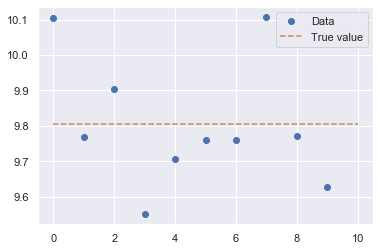

In [2]:
import scipy.constants
g_true = scipy.constants.g
# Generate some synthetic data
N = 10
sigma = 0.2
data = g_true + sigma * np.random.randn(N)
plt.plot(np.arange(N), data, 'o', label='Data')
plt.plot(np.linspace(0, N, 100), g_true*np.ones(100), '--', label='True value')
plt.legend(loc='best');

So, we have:
$$
X_n | g, \sigma \sim N(g, \sigma^2).
$$
So, the model says that the measured acceleration of gravity is around the true one with some Gaussian noise.

Assume that our prior state-of-knowledge over $g$ is:
$$
g | g_0, s_0 \sim N(g_0, s_0^2),
$$
with known $g_0 = 10$, $s_0 = 0.4$.

This is a conjugate model and the posterior over $g$ is given by:
$$
g|X \sim N(\tilde{g}, \tilde{s}^2),
$$
where, $\tilde{s}^2 = \left( \frac{N}{\sigma^2} + \frac{1}{s_0^2} \right)^{-1}$ and $\tilde{g} = \tilde{s}^2 \left( \frac{g_0}{s_0^2} + \frac{\sum_{i=1}^{N} X_i}{\sigma^2}\right)$.

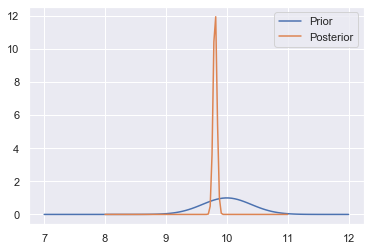

In [3]:
def post_mean_and_variance(prior_mean, prior_variance, data, likelihood_var):
    N = len(data)
    sigma2 = likelihood_var
    s02 = prior_variance
    m0 = prior_mean
    sumdata = np.sum(data)
    post_prec = (N/sigma2) + (1./s02)
    post_var = 1./post_prec
    post_mean = post_var * ((m0/s02) + (sumdata/sigma2))
    return post_mean, post_var

gtilde, s2tilde = post_mean_and_variance(10., 0.4**2, data, 0.1**2)

xs1 = np.linspace(7, 12, 100)
xs2 = np.linspace(8, 11, 100)
plt.plot(xs1, st.norm(loc=10., scale=0.4).pdf(xs1), label='Prior')
plt.plot(xs2, st.norm(loc=gtilde, scale=np.sqrt(s2tilde)).pdf(xs2), label='Posterior')
plt.legend(loc='best');

Now let's try to infer the posterior over $g$ using VI. Let specify our joint log probability model first.

In [9]:
from autograd.scipy.stats.norm import logpdf as normlogpdf
from autograd import grad, elementwise_grad as egrad 
from autograd import numpy as anp
from autograd.numpy import random as npr
from autograd.misc.optimizers import adam 

g0, s0 = 10., 0.4
sigma = 0.1

def logprior(g):
    return normlogpdf(g, g0, s0)

def loglikelihood(g):
    return anp.sum(normlogpdf(data, g, sigma))

def logjoint(g):
    return logprior(g) + loglikelihood(g)

Now we need to specify a parameterized approximate posterior, $q_{\phi}(\cdot)$. The obvious choice here is a Gaussian:
$$
q_{\phi}(g) = N(g | \phi_1, \exp(\phi_2)^2),
$$
where, $\phi = (\phi_1, \phi_2)$ are the variational parameters. The ELBO needs to be maximized wrt to $\phi$. Let go ahead and set up the ELBO. Recall that the ELBO is given by:
$$
\mathcal{L}(\phi) =  \mathbb{E}_{q(\theta)}[\log p(\theta, \mathcal{D})] + \mathbb{H}[q(\theta)].
$$

To optimize the ELBO, we will need to compute an expectation over the variational distribution $q$ (first term on the RHS in the above equation). This cannot be done analytically. Instead, we resort to a Monte Carlo approximation:

$$
\mathbb{E}_q [\log p(\theta, \mathbf{x})] \approx \frac{1}{S}\sum_{s=1}^{S}   \log p(\theta^{(s)}, \mathbf{x}),
$$
where the samples $\theta^{(s)}$ are drawn from $q$.

In [10]:
def norm_entropy(s):
    s2 = s*s
    return 0.5 * (1. + anp.log(2.*anp.pi*s2))

def ELBO(phi, num_samples):
    m, s = phi[0], anp.exp(phi[1])
    
    # compute the entropy 
    entropy = norm_entropy(s)
    
    # compute the avg. datafit
    samples = m + s*npr.randn(num_samples)
    datafit = 0.
    for sample in samples:
        datafit += logjoint(sample)
    datafit = datafit/num_samples
    
    # return the elbo
    elbo = datafit + entropy
    return elbo

def negELBO(phi, num_samples=5):
    return -ELBO(phi, num_samples)

Now let's optimize the lower bound using simple stochastic gradient descent (SGD).

In [11]:
# get the gradient of the negative elbo 
gradnegelbo = grad(negELBO)

# give initial values to the variational parameters 
phi_init = anp.array([9., -1.])

# optimize 
num_iter = 1000
phi_i = phi_init
step_size = 1e-3
num_samples = 10
elbos = []
bestnegelbo = np.inf
for i in range(num_iter):
    negelbo = negELBO(phi_i, num_samples)
    elbos.append(-negelbo)
    grad_i = gradnegelbo(phi_i, num_samples)
    phi_next = phi_i - step_size*grad_i
    
    if (i+1)%50 == 0:
        print('Iteration [%4d] : ELBO = %.5f'%(i+1, -negelbo))
        if negelbo < bestnegelbo:
            phi_opt = phi_i
            bestnegelbo = negelbo   
    phi_i = phi_next

Iteration [  50] : ELBO = -9.21201
Iteration [ 100] : ELBO = -4.84956
Iteration [ 150] : ELBO = -4.09946
Iteration [ 200] : ELBO = -5.56783
Iteration [ 250] : ELBO = -4.04894
Iteration [ 300] : ELBO = -3.92402
Iteration [ 350] : ELBO = -3.97946
Iteration [ 400] : ELBO = -5.41017
Iteration [ 450] : ELBO = -3.71515
Iteration [ 500] : ELBO = -4.18543
Iteration [ 550] : ELBO = -4.49978
Iteration [ 600] : ELBO = -3.88569
Iteration [ 650] : ELBO = -3.79997
Iteration [ 700] : ELBO = -4.83628
Iteration [ 750] : ELBO = -4.34290
Iteration [ 800] : ELBO = -4.38020
Iteration [ 850] : ELBO = -3.61004
Iteration [ 900] : ELBO = -4.05194
Iteration [ 950] : ELBO = -3.96508
Iteration [1000] : ELBO = -4.10269


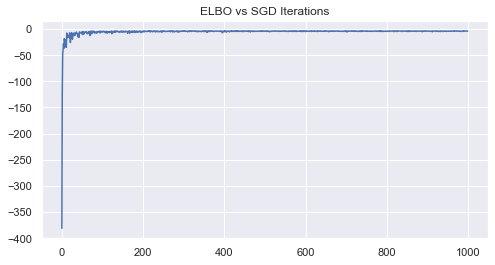

In [12]:
plt.figure(figsize=(8, 4))
plt.plot(np.arange(num_iter), elbos)
plt.title('ELBO vs SGD Iterations');

In [13]:
# get the posterior distribution
postmean = phi_opt[0]
poststdev = np.exp(phi_opt[1])
gpost = st.norm(postmean, poststdev)

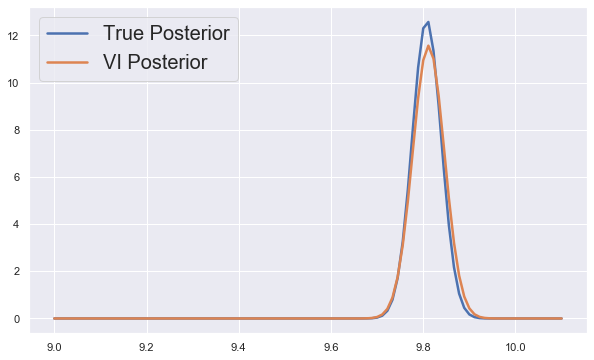

In [14]:
# compare the VI posterior with the analytical distribution
xs = np.linspace(9, 10.1, 100)
plt.figure(figsize=(10, 6))
plt.plot(xs, st.norm(loc=gtilde, scale=np.sqrt(s2tilde)).pdf(xs), label='True Posterior', linewidth=2.5)
plt.plot(xs, gpost.pdf(xs), label='VI Posterior', linewidth=2.5)
plt.legend(loc='best', fontsize=20);

As you can see our approximation of the posterior is not exact, but close. The normal-normal model is a very simple example with 1 latent variable.  In practice setting up the variational posterior for all latent variables, keeping track of transformations and optimizing the variational parameters can become highly tedious for models of any reasonable level of complexity. From this point on, we will use `PyMC3`'s ADVI capabilities.  

## Example 2 - Coin-toss example 

Just like in the MCMC lecture, let's look at the process of setting up a model and performing variational inference and diagnostics with the coin toss example.  

The probabilistic model is as follows. We observe binary coin toss data:
$$
x_i|\theta \overset{\mathrm{i.i.d.}}{\sim} \mathrm{Bernoulli}(\theta),
$$
for $i=1, \dots, N$.

The prior over the latent variable $\theta$ is a Beta distribution:
$$
\theta \sim \mathrm{Beta}([2, 2]).
$$
We assign the prior as a Beta distribution with shape parameters 2 and 2, corresponding to a weak apriori belief that the coin is most likely fair.

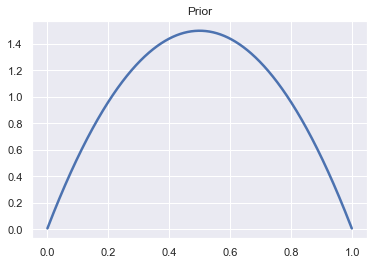

In [15]:
thetaprior = st.beta(2., 2.)
x = np.linspace(0.001, 0.999, 1000)
plt.plot(x, thetaprior.pdf(x), linewidth=2.5)
plt.title('Prior');

We wish to perform posterior inference on $\theta$:
$$
p(\theta| x_1, \dots, x_N) \propto p(\theta) \prod_{i=1}^{N} p(x_i | \theta).
$$
Since this is a conjugate model, we know the posterior in closed form:
$$
\theta | x_1, \dots, x_N = \mathrm{Beta}(\theta, 2+ \sum_{i=1}^N x_i, 2 + N - \sum_{i=1}^Nx_i )
$$

Let's generate some fake data and get the analytical posterior for comparison.

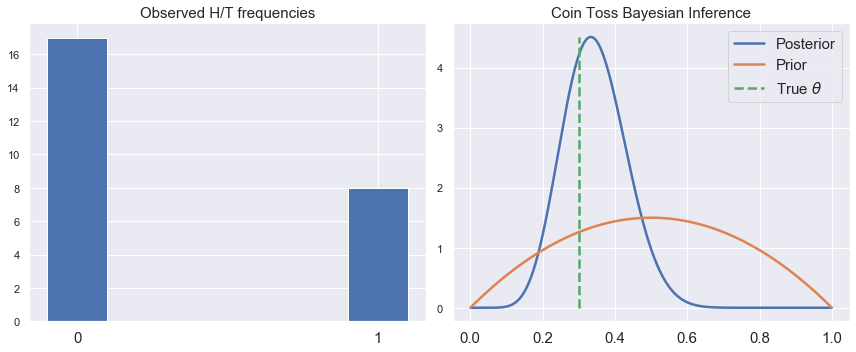

In [17]:
thetatrue =0.3
N = 25
data = np.random.binomial(1, thetatrue, size=(N,))
nheads = data.sum()
ntails = N - nheads
theta_post = st.beta(2. + nheads, 2. + ntails)

# plot data 
plt.figure(figsize=(12, 5))
plt.subplot(121)
_=plt.bar(*np.unique(data, return_counts=True), width=0.2)
_=plt.xticks([0, 1], fontsize=15)
_=plt.title('Observed H/T frequencies', fontsize = 15)

# plot posterior
plt.subplot(122)
x = np.linspace(0.001, 0.999, 1000)
postpdf = theta_post.pdf(x)
y = np.linspace(0., np.max(postpdf), 100)
plt.plot(x, postpdf, linewidth=2.5, label='Posterior')
plt.plot(x, thetaprior.pdf(x), linewidth=2.5, label='Prior')
plt.plot(thetatrue*np.ones_like(y), y, linewidth=2.5, linestyle='--', label='True $\\theta$')
plt.legend(loc='best', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Coin Toss Bayesian Inference', fontsize = 15);

plt.tight_layout()

Now let's setup the `PyMC3` model and do variational inference. To do this, we simply need to setup the model like in the MCMC setup, and call `pymc3.variational.ADVI` to do inference.

In [18]:
model = pm.Model()
with model:
    theta = pm.Beta('theta', 2., 2.)
    x = pm.Bernoulli('x', theta, observed=data)
model

In [19]:
num_iter = 20000
num_samples = 20
with model:
    method = pm.ADVI()  # <- This method makes q a diagonal Gaussian
    #method = pm.FullRankADVI() # <- this method makes q a Gaussian with full rank cov. matrix
    #method = pm.SVGD() # <- Stein Variational Gradient descent (see additional readings)
    #method = pm.NFVI() # <- Normalizing flow Variational inference (see additional readings)
    vi_approx = pm.fit(n=num_iter, 
                       method=method,
                       progressbar=True, 
                       obj_n_mc=num_samples)

Average Loss = 16.902: 100%|██████████| 20000/20000 [00:14<00:00, 1359.17it/s]
Finished [100%]: Average Loss = 16.902


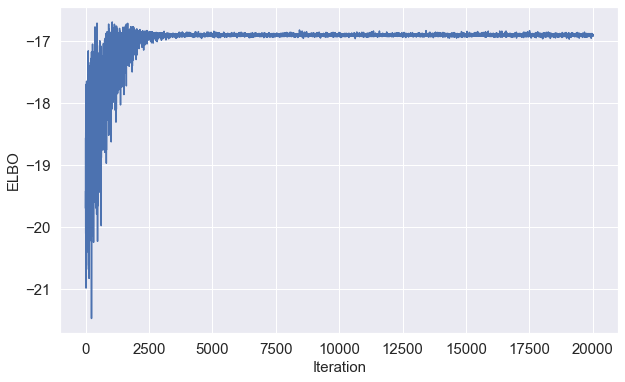

In [20]:
# Let's check the optimization convergence 
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_iter), -vi_approx.hist)
plt.ylabel('ELBO', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15);

Clearly, we see that the optimization has converged. 

Recall that ADVI transforms every variable with finite support with an invertible function to obtain a variable with support over the entire $\mathbb{R}$. The variational posterior is then set to be a diagonal Gaussian. 
In the coin toss problem, the latent variable $\theta \in (0, 1)$ is transformed with the logit function $g(\theta ) = \log \frac{\theta}{1 - \theta}$, i.e., `PyMC3` works with the transformed variable $\tilde{\theta} = g(\theta)$. 
The posterior over $\tilde{\theta}$ is then approximated with a Gaussian $q_{\phi}(\tilde{\theta}) = \mathcal{N}(\mu, \sigma^2)$, where, $\phi = (\mu, \sigma)$ are the variational parameters. Let's get these parameters and visualize the posterior. 

In [22]:
# get the variational parameters a
mu, sigma = vi_approx.mean.eval(), vi_approx.std.eval()
qtheta_transformed = pm.Normal.dist(mu, sigma)
transform = pm.transforms.logodds
def qthetalogp(x):
    x = tt.as_tensor(x)
    y = transform.forward(x)
    logpy = qtheta_transformed.logp(y)
    logpx = logpy + transform.jacobian_det(x)
    return logpx.eval()

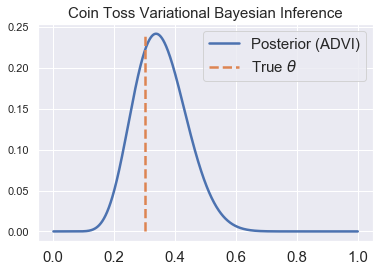

In [23]:
x = np.linspace(0.001, 0.999, 1000)
postpdf = theta_post.pdf(x)
postpdf_vi = np.exp(qthetalogp(x))
y = np.linspace(0., np.max(postpdf_vi), 100)
plt.plot(x, postpdf_vi, linewidth=2.5, label='Posterior (ADVI)')
plt.plot(thetatrue*np.ones_like(y), y, linewidth=2.5, linestyle='--', label='True $\\theta$')
plt.legend(loc='best', fontsize=15)
plt.xticks(fontsize=15)
plt.title('Coin Toss Variational Bayesian Inference', fontsize = 15);

###  Posterior predictive distribution

To estimate posterior predictive expectations, we first create a `MultiTrace` object out of the results of the ADVI stored in `vi_approx`.  

In [24]:
trace = vi_approx.sample(2000)

From this point all of the computation is exactly as it was when doing MCMC. Let's generate some synthetic datasets from the posterior predictive distribution.

In [25]:
pp_samples = pm.sample_posterior_predictive(trace=trace, samples=500, model=model)
x_post = pp_samples['x']
x_post.shape # num samples of theta \times size of the dataset 

/Users/rohitkt10/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:00<00:00, 2854.66it/s]


(500, 25)

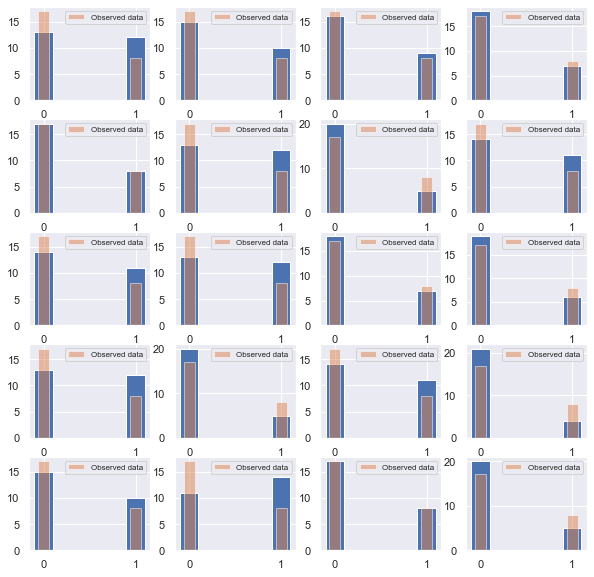

In [26]:
plt.figure( figsize=(10, 10) )
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.bar(*np.unique(x_post[i], return_counts=True), width=0.2)
    plt.bar(*np.unique(data, return_counts=True), width=0.12, 
            alpha=0.5, label='Observed data')
    plt.xticks([0, 1])
    plt.legend(loc='best', fontsize=8)

## Example 3 - Challenger Space Shuttle Disaster

Let's revisit this example from the MCMC lecture.

In [27]:
# load data 
challenger_data = np.genfromtxt("challenger_data.csv", skip_header=1,
                                usecols=[1, 2], missing_values="NA",
                                delimiter=",")
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]
print("Temp (F), O-Ring failure?")
print(challenger_data)

Temp (F), O-Ring failure?
[[66.  0.]
 [70.  1.]
 [69.  0.]
 [68.  0.]
 [67.  0.]
 [72.  0.]
 [73.  0.]
 [70.  0.]
 [57.  1.]
 [63.  1.]
 [70.  1.]
 [78.  0.]
 [67.  0.]
 [53.  1.]
 [67.  0.]
 [75.  0.]
 [70.  0.]
 [81.  0.]
 [76.  0.]
 [79.  0.]
 [75.  1.]
 [76.  0.]
 [58.  1.]]


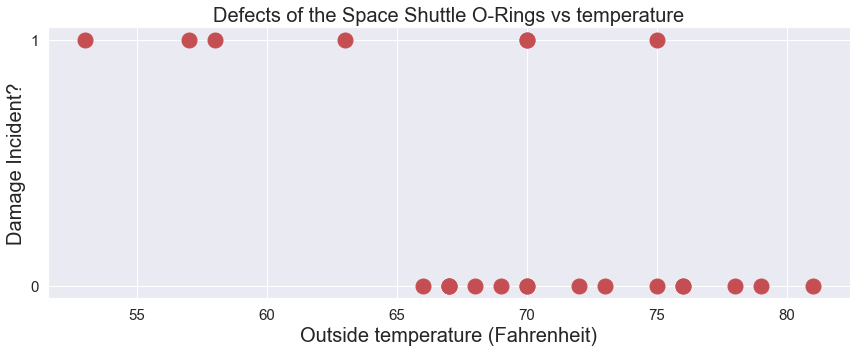

In [28]:
# plot it, as a function of temperature (the first column)
plt.figure(figsize=(12, 5))
plt.plot(challenger_data[:, 0], challenger_data[:, 1], 'ro', 
         markersize=15)
plt.ylabel("Damage Incident?",fontsize=20)
plt.xlabel("Outside temperature (Fahrenheit)",fontsize=20)
plt.title("Defects of the Space Shuttle O-Rings vs temperature",
          fontsize=20)
plt.yticks([0, 1], fontsize=15)
plt.xticks(fontsize=15)
plt.tight_layout()

### Probabilistic model 

The defect probability is modeled as a function of the outside temperature:
$$\sigma(t) = \frac{1}{ 1 + e^{ \;\beta t + \alpha } } $$.

The goal is to infer the latent variables $\alpha$ and $\beta$. 

We set normal priors on the latent variables - $\alpha = \mathcal{N}(0, 10^2)$ and $\beta = \mathcal{N}(0, 10^2)$ and the likelihood model is giveb by $p(x_i | \alpha, \beta, t) = \mathrm{Bern}(x_i | \sigma(t; \alpha, \beta) )$.

The graphical model for this problem is shown below.

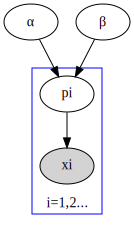

In [29]:
gcp = Digraph('space_shuttle_disaster')

# setup the nodes 
gcp.node('alpha', label='<&alpha;>')
gcp.node('beta', label='<&beta;>')
with gcp.subgraph(name='cluster_0') as sg:
    sg.node('pi', label='<p<sub>i</sub>>')
    sg.node('xi', label='<x<sub>i</sub>>', style='filled')
    sg.attr(color='blue')
    sg.attr(label='i=1,2...')
    sg.attr(labelloc='b')

# setup the edges 
gcp.edge('alpha', 'pi')
gcp.edge('beta', 'pi')
gcp.edge('pi', 'xi')
gcp

###  `PyMC3` model 

In [30]:
# gather the data and apply preprocessing if any 
temp = challenger_data[:, 0]
temp_scaled = (temp - np.mean(temp))/np.std(temp)
data = challenger_data[:, 1]

# instantiate the pymc3 model
challenger_model = pm.Model()

# define the graph 
with challenger_model:
    # define the prior
    alpha = pm.Normal('alpha', mu=0., sigma=10.)
    beta = pm.Normal('beta', mu=0., sigma=10.)
    
    # get the probabilities of failure at each observed temp 
    p = pm.Deterministic('p', 1./(1. + tt.exp(alpha + beta*temp_scaled)))
    
    # define the likelihood 
    x = pm.Bernoulli('x', p=p, observed=data)
print("Challenger space shuttle disaster model:")
challenger_model

Challenger space shuttle disaster model:


### Inference and posterior visualization

Now let's infer the hidden parameters with VI. We will use both mean-field (i.e. diagonal covariance Gaussian) ADVI and full-rank (i.e. full rank covariance matrix Gaussian) ADVI. 

In [31]:
num_iter = 20000
num_samples = 20
with challenger_model:
    method_1 = pm.ADVI()  # <- This method makes q a diagonal Gaussian
    vi_approx_1 = pm.fit(n=num_iter, 
                       method=method_1,
                       progressbar=True, 
                       obj_n_mc=num_samples)

Average Loss = 15.671: 100%|██████████| 20000/20000 [00:15<00:00, 1327.99it/s]
Finished [100%]: Average Loss = 15.672


In [32]:
with challenger_model:
    method_2 = pm.FullRankADVI()  # <- This method makes q a diagonal Gaussian
    vi_approx_2 = pm.fit(n=num_iter, 
                       method=method_2,
                       progressbar=True, 
                       obj_n_mc=num_samples)

  0%|          | 0/20000 [00:00<?, ?it/s]/Users/rohitkt10/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/rohitkt10/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/rohitkt10/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `a

Let's make sure that the ELBO has converged.

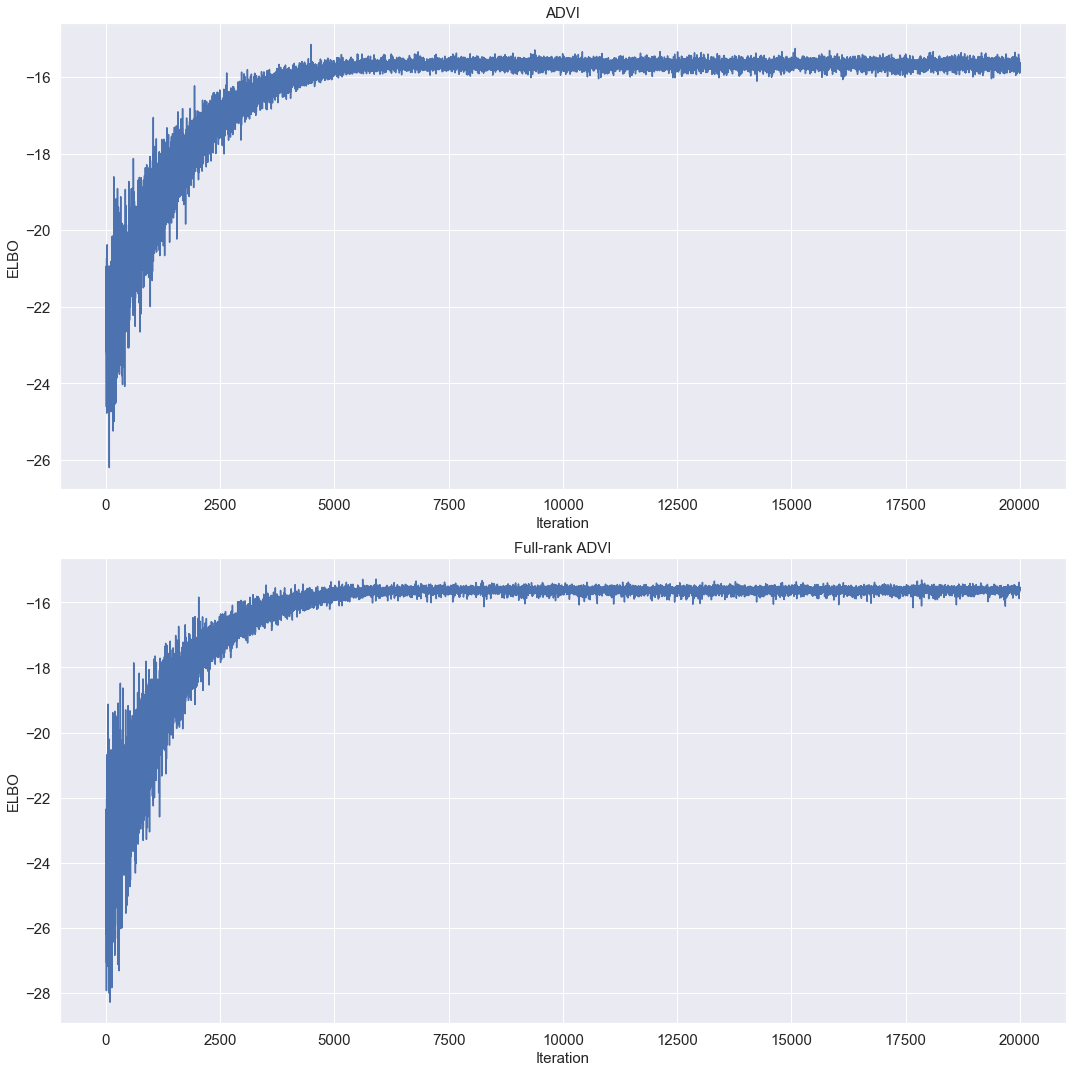

In [33]:
plt.figure(figsize=(15, 15))

# ADVI
plt.subplot(211)
plt.plot(np.arange(num_iter), -vi_approx_1.hist)
plt.ylabel('ELBO', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('ADVI', fontsize=15);

# Full rank ADVI
plt.subplot(212)
plt.plot(np.arange(num_iter), -vi_approx_2.hist)
plt.ylabel('ELBO', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('Full-rank ADVI', fontsize=15)

plt.tight_layout()

We see that both methods have converged to a local minimum.

Let's get the variational posteriors $q$ for each case and compare.

In [34]:
# get the variational parameters and compute the post. pdf over a grid for ADVI
mu, sigma = vi_approx_1.mean.eval(), vi_approx_1.std.eval()
qtheta = pm.MvNormal.dist(mu=mu, cov=np.diag(sigma), shape=2)
x1max, x2max = mu + 3.*sigma
x1min, x2min = mu - 3.*sigma
x1 = np.linspace(x1min, x1max, 50)
x2 = np.linspace(x2min, x2max, 50)
names = [g.name for g in vi_approx_1.groups[0].group]
X1, X2 = np.meshgrid(x1, x2)
Xgrid = np.vstack([X1.flatten(), X2.flatten()]).T
advipdf = np.exp(qtheta.logp(tt.as_tensor(Xgrid)).eval()).reshape((50, 50))

In [35]:
# get the variational parameters and compute the post. pdf over a grid for full rank ADVI
mu, cov = vi_approx_2.mean.eval(), vi_approx_2.cov.eval()
sigma = np.sqrt(np.diag(cov))
qtheta = pm.MvNormal.dist(mu=mu, cov=cov, shape=2)

x1max, x2max = mu + 3.*sigma
x1min, x2min = mu - 3.*sigma
x1 = np.linspace(x1min, x1max, 50)
x2 = np.linspace(x2min, x2max, 50)
names = [g.name for g in vi_approx_2.groups[0].group]
X1, X2 = np.meshgrid(x1, x2)
Xgrid = np.vstack([X1.flatten(), X2.flatten()]).T
advifullrankpdf = np.exp(qtheta.logp(tt.as_tensor(Xgrid)).eval()).reshape((50, 50))

/Users/rohitkt10/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


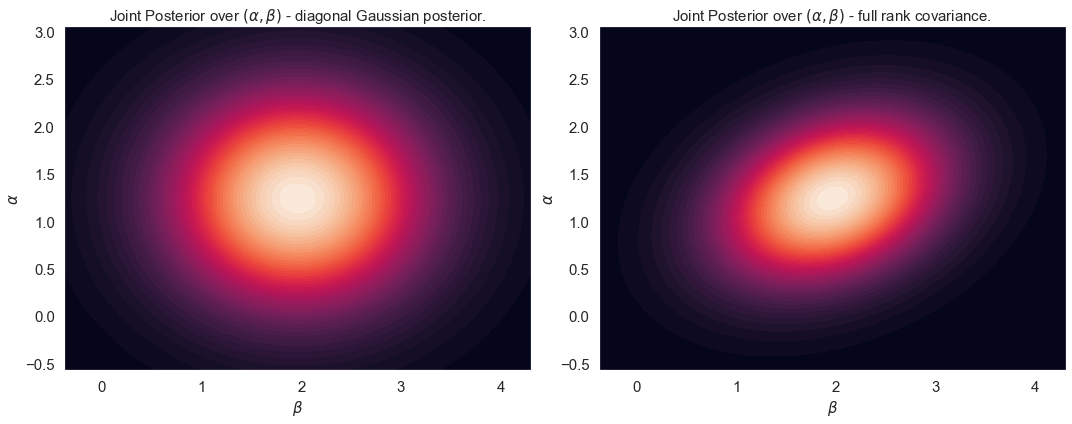

In [36]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.contourf(X1, X2, advipdf, 50)
plt.xlabel('$\\'+names[0]+'$', fontsize=15)
plt.ylabel('$\\'+names[1]+'$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Joint Posterior over $(\\alpha, \\beta)$ - diagonal Gaussian posterior.', fontsize=15)

plt.subplot(122)
plt.contourf(X1, X2, advifullrankpdf, 50)
plt.xlabel('$\\'+names[0]+'$', fontsize=15)
plt.ylabel('$\\'+names[1]+'$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Joint Posterior over $(\\alpha, \\beta)$ - full rank covariance.', fontsize=15)

plt.tight_layout()

Note how the simple diagonal Gaussian does not capture correlation between $\alpha$ and $\beta$,something we are able to recover with the full rank ADVI.

###  Posterior predictive distribution

Here we will use a trace generated from the full rank Gaussian posterior to make posterior predictions. 

In [37]:
trace = vi_approx_2.sample(10000)

with challenger_model:
    ppsamples = pm.sample_posterior_predictive(trace=trace, 
                                               samples=2000,
                                               var_names=['p'])['p']

/Users/rohitkt10/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/Users/rohitkt10/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:00<00:00, 4036.76it/s]


In [38]:
# get posterior predictive mean and 95% interval
ppmean = ppsamples.mean(axis=0)
pp_lower, pp_upper = np.percentile(ppsamples, axis=0, q=[2.5, 97.5])

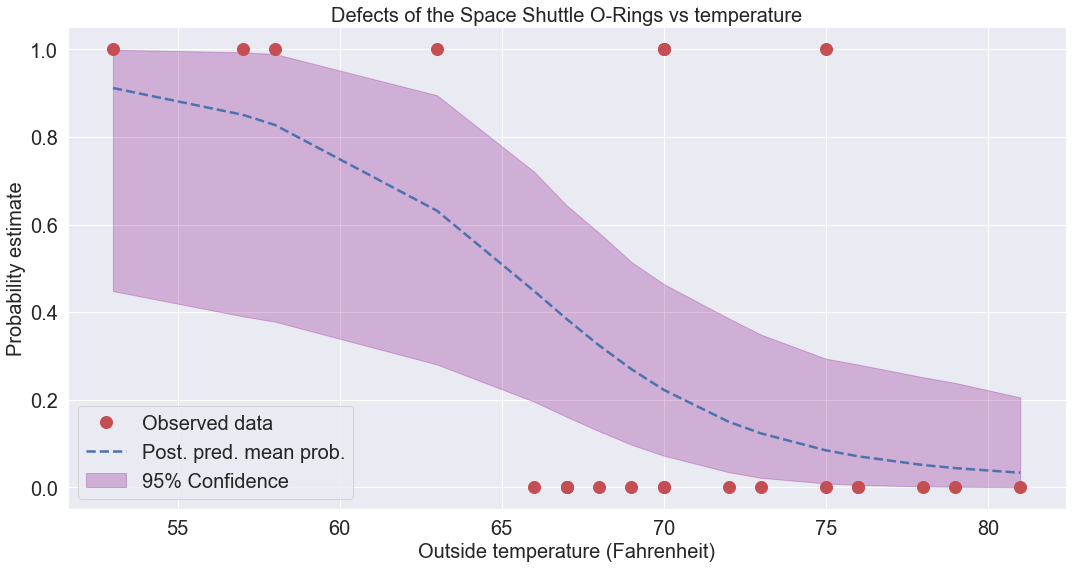

In [39]:
plt.figure(figsize=(15, 8))
plt.plot(temp, data, 'ro', markersize=12, label='Observed data')
idx=np.argsort(temp)
plt.plot(temp[idx], ppmean[idx], linestyle='--', linewidth=2.5, 
         label='Post. pred. mean prob.')
plt.fill_between(temp[idx], pp_lower[idx], pp_upper[idx], 
                color='purple', alpha=0.25, label='95% Confidence')
plt.ylabel("Probability estimate",fontsize=20)
plt.xlabel("Outside temperature (Fahrenheit)",fontsize=20)
plt.title("Defects of the Space Shuttle O-Rings vs temperature",
          fontsize=20)
plt.yticks(np.arange(0., 1.01, 0.2), fontsize=20)
plt.xticks(fontsize=20)
plt.legend(loc='best', fontsize=20)
plt.tight_layout()